In [1]:
% env CUDA_VISIBLE_DEVICES=2

env: CUDA_VISIBLE_DEVICES=2


In [2]:
import tensorflow as tf
import tensorflow_hub as hub

In [5]:
questions = open('../data/quora/quora.txt').read().splitlines()

In [6]:
embedder_url = "https://tfhub.dev/google/universal-sentence-encoder/2"

with tf.Graph().as_default():
    embed = hub.Module(embedder_url)
    embeddings = embed(questions)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        sess.run(tf.tables_initializer())

        embeddings_vec = sess.run(embeddings)

INFO:tensorflow:Using /tmp/tfhub_modules to cache modules.
INFO:tensorflow:Downloading TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder/2'.
INFO:tensorflow:Downloaded TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder/2'.
INFO:tensorflow:Initialize variable module/Embeddings_en/sharded_0:0 from checkpoint b'/tmp/tfhub_modules/1fb57c3ffe1a38479233ee9853ddd7a8ac8a8c47/variables/variables' with Embeddings_en/sharded_0
INFO:tensorflow:Initialize variable module/Embeddings_en/sharded_1:0 from checkpoint b'/tmp/tfhub_modules/1fb57c3ffe1a38479233ee9853ddd7a8ac8a8c47/variables/variables' with Embeddings_en/sharded_1
INFO:tensorflow:Initialize variable module/Embeddings_en/sharded_10:0 from checkpoint b'/tmp/tfhub_modules/1fb57c3ffe1a38479233ee9853ddd7a8ac8a8c47/variables/variables' with Embeddings_en/sharded_10
INFO:tensorflow:Initialize variable module/Embeddings_en/sharded_11:0 from checkpoint b'/tmp/tfhub_modules/1fb57c3ffe1a38479233ee9853ddd7a8ac8a8c47/var

In [10]:
import numpy as np

np.save('../data/embeddings_from_mt', embeddings_vec)

In [11]:
# Let's free GPU before using our VAE pytorch model
sess.close()

In [1]:
from torchtext import data
from torchtext.data import Field, Dataset, Example

batch_size = 64

questions_bpe = open('../data/quora/quora.tok.bpe').read().splitlines()
text = Field(init_token='<bos>', eos_token='<eos>', batch_first=True)
examples = [Example.fromlist([s], [('text', text)]) for s in questions_bpe]
dataset = Dataset(examples, [('text', text)])
text.build_vocab(dataset)
dataloader = data.BucketIterator(dataset, batch_size, train=False, sort=False)

In [2]:
import sys; sys.path.append('..')

import torch
import numpy as np
from tqdm import tqdm
from firelab.utils import cudable

from src.models import RNNEncoder

embeddings = []
emb_size = 1024
hid_size = 1024

encoder = cudable(RNNEncoder(emb_size, hid_size, len(text.vocab)))
encoder.load_state_dict(torch.load('../experiments/nae/checkpoints/encoder-50382.pth'))

def embeddings_from_batch(batch):
    batch.text = cudable(batch.text)
    inputs, trg = batch.text[:, :-1], batch.text[:, 1:]
    encodings = encoder(inputs)
    
    return encodings
    
for batch in tqdm(dataloader):
    embeddings.append(embeddings_from_batch(batch).detach().cpu().numpy())

  0%|          | 0/8406 [00:00<?, ?it/s]/home/universome/pyvenvs/zoo/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
100%|██████████| 8406/8406 [01:01<00:00, 137.44it/s]


In [3]:
np.save('../data/embeddings_from_nae', np.concatenate(embeddings))

In [4]:
classes = open('../data/quora/classes.txt').read().splitlines()
classes = [[int(qid) for qid in c.split()] for c in classes]

In [5]:
mt_embeddings = np.load('../data/embeddings_from_mt.npy')
vae_embeddings = np.load('../data/embeddings_from_nae.npy')

In [6]:
from sklearn.metrics.pairwise import cosine_similarity

mt_mean_cosines = []
vae_mean_cosines = []

mt_std_cosines = []
vae_std_cosines = []

for cls in classes:
    if len(cls) == 1: continue
        
    from sklearn.metrics.pairwise import cosine_similarity

    mt_sim_matrix = cosine_similarity(mt_embeddings[cls])
    vae_sim_matrix = cosine_similarity(vae_embeddings[cls])
    
    # Taking upper diagonal triangle to exclude duplicates
    indices = np.triu_indices(mt_sim_matrix.shape[0], 1)
    
    mt_mean_cosines.append(mt_sim_matrix[indices].mean())
    mt_std_cosines.append(mt_sim_matrix[indices].std())
    
    vae_mean_cosines.append(vae_sim_matrix[indices].mean())
    vae_std_cosines.append(vae_sim_matrix[indices].std())

In [7]:
np.array(vae_mean_cosines).mean(), np.array(mt_mean_cosines).mean()

(0.58437586, 0.30632636)

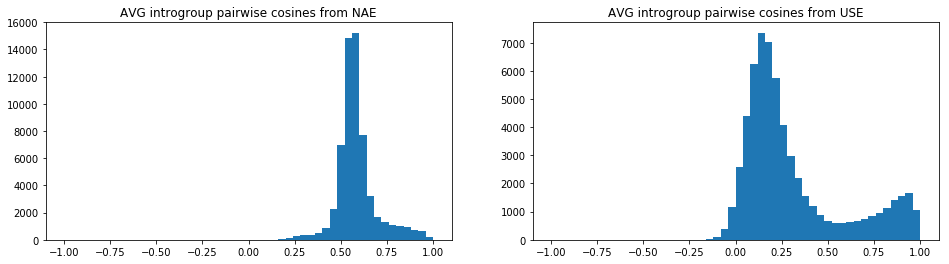

In [9]:
import matplotlib.pyplot as plt
% matplotlib inline

plt.figure(figsize=(16,4))

plt.subplot(1,2,1)
plt.title('AVG introgroup pairwise cosines from NAE')
plt.hist(vae_mean_cosines, bins=50, range=(-1,1));

plt.subplot(1,2,2)
plt.title('AVG introgroup pairwise cosines from USE')
plt.hist(mt_mean_cosines, bins=50, range=(-1,1));